In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import tensorflow as tf

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout, BatchNormalization #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
df_usd = pd.read_parquet("./minio/usd/part-00000-18b834c3-cd6d-42ae-82c3-638999ff6d84-c000.snappy.parquet", engine="pyarrow")
df_usd.head()

,ngay,ma_ngoai_te,ten_ngoai_te,mua_chuyen_khoan,ban
0,2020-02-01,USD,US DOLLAR,23165.0,23305.0
1,2020-02-02,USD,US DOLLAR,23165.0,23305.0
2,2020-02-03,USD,US DOLLAR,23200.0,23340.0
3,2020-02-04,USD,US DOLLAR,23170.0,23310.0
4,2020-02-05,USD,US DOLLAR,23160.0,23300.0


In [3]:
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ngay              1911 non-null   datetime64[ns]
 1   ma_ngoai_te       1911 non-null   object        
 2   ten_ngoai_te      1911 non-null   object        
 3   mua_chuyen_khoan  1911 non-null   float64       
 4   ban               1911 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 74.8+ KB


In [4]:
df_usd.describe()

,ngay,mua_chuyen_khoan,ban
count,1911,1911.000000,1911.000000
mean,2022-09-13 00:00:00,23666.414443,23934.197279
min,2020-02-01 00:00:00,22480.000000,22745.000000
25%,2021-05-23 12:00:00,22985.000000,23170.000000
50%,2022-09-13 00:00:00,23300.000000,23620.000000
75%,2024-01-03 12:00:00,24390.000000,24730.000000
max,2025-04-25 00:00:00,25835.000000,26195.000000
std,NaN,885.147984,926.810272


In [5]:
print(df_usd.dtypes)

ngay                datetime64[ns]
ma_ngoai_te                 object
ten_ngoai_te                object
mua_chuyen_khoan           float64
ban                        float64
dtype: object


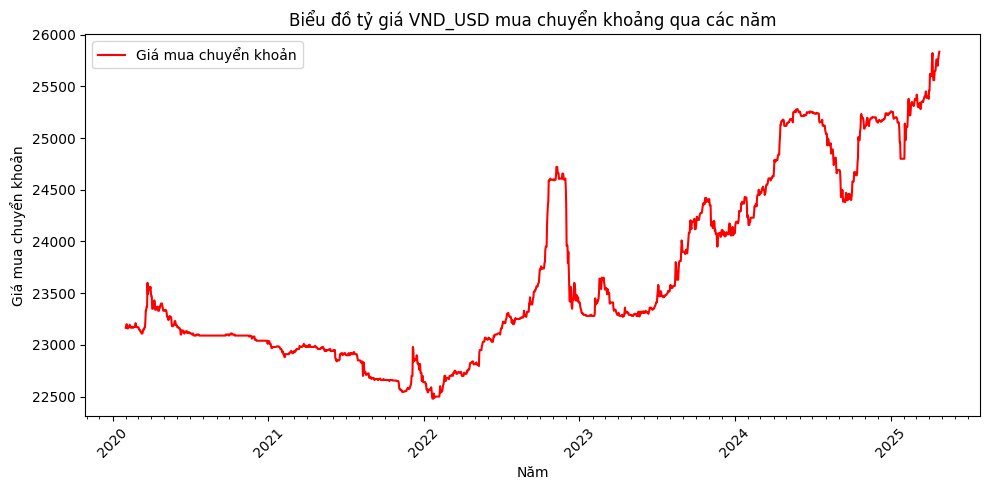

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(df_usd['ngay'].values, df_usd['mua_chuyen_khoan'].values, label='Giá mua chuyển khoản', color='red')

plt.xlabel('Năm')
plt.ylabel('Giá mua chuyển khoản')
plt.title('Biểu đồ tỷ giá VND_USD mua chuyển khoảng qua các năm')
plt.legend(loc='best')

# Định dạng trục x
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
df_usd_ML = pd.DataFrame(df_usd, columns=['ngay','mua_chuyen_khoan'])
df_usd_ML.index = df_usd_ML.ngay
df_usd_ML.drop('ngay', axis = 1, inplace=True)
df_usd_ML.head()

,mua_chuyen_khoan
ngay,
2020-02-01,23165.0
2020-02-02,23165.0
2020-02-03,23200.0
2020-02-04,23170.0
2020-02-05,23160.0


In [8]:
print(df_usd_ML.columns)

Index(['mua_chuyen_khoan'], dtype='object')


In [9]:
data = df_usd_ML.values


In [10]:
data

array([[23165.],
       [23165.],
       [23200.],
       ...,
       [25781.],
       [25814.],
       [25835.]])

In [11]:
#hàm hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))

#chuẩn hóa dữ train
scale_data = sc.fit_transform(data)

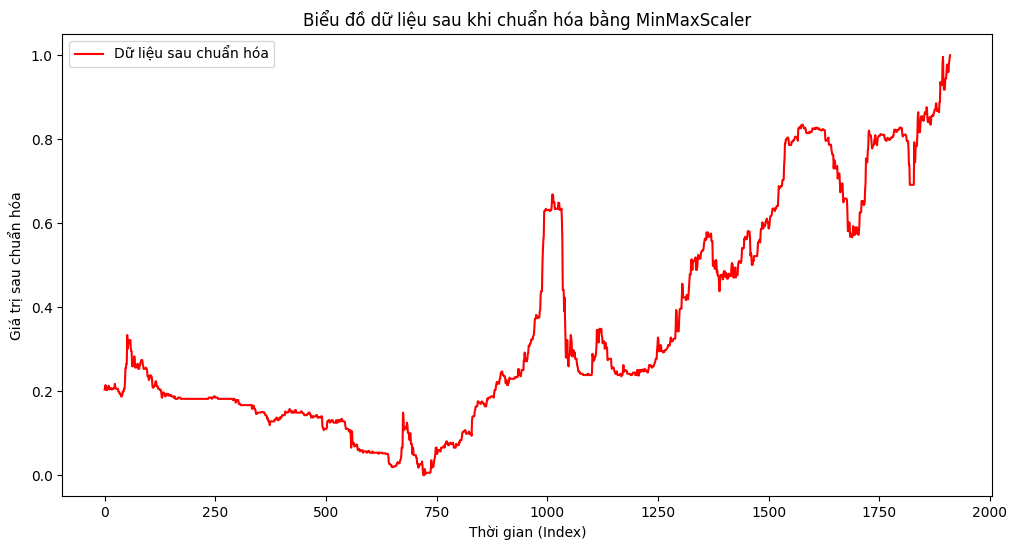

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(scale_data, label="Dữ liệu sau chuẩn hóa", color="red")

plt.xlabel("Thời gian (Index)")
plt.ylabel("Giá trị sau chuẩn hóa")
plt.title("Biểu đồ dữ liệu sau khi chuẩn hóa bằng MinMaxScaler")
plt.legend()
plt.show()


In [13]:
window_size = 14
X_train, Y_train = [], []

for i in range(len(scale_data) - window_size - 1):  # trừ 1 vì lấy 2 output
    X_train.append(scale_data[i:i + window_size])  # 14 giá trị làm input
    Y_train.append(scale_data[i + window_size : i + window_size + 2])  # 2 giá trị output kế tiếp

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Kiểm tra shape dữ liệu
print('X_train shape:', X_train.shape)  # (số mẫu, 14)
print('Y_train shape:', Y_train.shape)  # (số mẫu, 2)

# Phân chia tập train-test
split_index = int(0.9 * len(X_train))
X_train, X_test = X_train[:split_index], X_train[split_index:]
Y_train, Y_test = Y_train[:split_index], Y_train[split_index:]

#Reshape cho model LSTM
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))


X_train shape: (1896, 14, 1)
Y_train shape: (1896, 2, 1)


In [14]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", Y_train.shape)
print("y_test shape:", Y_test.shape)

X_train shape: (1706, 14, 1)
X_test shape: (190, 14, 1)
y_train shape: (1706, 2, 1)
y_test shape: (190, 2, 1)


# MODEL

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Xây dựng mô hình BiLSTM
model = Sequential()
# Lớp LSTM đầu tiên (return_sequences=True để kết nối lớp tiếp theo)
model.add(LSTM(units=64, return_sequences=True, input_shape=(14, 1)))
model.add(BatchNormalization())  # Ổn định dữ liệu đầu ra
# Lớp BiLSTM thứ hai
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
# Dropout để giảm overfitting
model.add(Dropout(0.5))
# Lớp Dense đầu ra với 2 neuron (dự báo 2 giá trị)
model.add(Dense(2))
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa rmsprop
model.compile(loss='mean_absolute_error', optimizer='rmsprop')


# huấn luyện mô hình

In [16]:
save_model = "./Model/case_3/LSTM/model_14in2out/save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')

import time
start_model = time.time()  # Bắt đầu đo thời gian
model.fit(X_train,Y_train,epochs=100,batch_size=50,validation_split=0.4,verbose=2,callbacks=[best_model])
end_model = time.time()  # Kết thúc đo thời gian
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")

Epoch 1/100

Epoch 1: loss improved from inf to 0.89696, saving model to ./Model/case_3/LSTM/model_14in2out\save_model.hdf5
21/21 - 4s - loss: 0.8970 - val_loss: 0.3662 - 4s/epoch - 209ms/step
Epoch 2/100

Epoch 2: loss improved from 0.89696 to 0.70800, saving model to ./Model/case_3/LSTM/model_14in2out\save_model.hdf5
21/21 - 0s - loss: 0.7080 - val_loss: 0.3723 - 450ms/epoch - 21ms/step
Epoch 3/100

Epoch 3: loss improved from 0.70800 to 0.64541, saving model to ./Model/case_3/LSTM/model_14in2out\save_model.hdf5
21/21 - 0s - loss: 0.6454 - val_loss: 0.3508 - 468ms/epoch - 22ms/step
Epoch 4/100

Epoch 4: loss improved from 0.64541 to 0.55148, saving model to ./Model/case_3/LSTM/model_14in2out\save_model.hdf5
21/21 - 0s - loss: 0.5515 - val_loss: 0.3978 - 470ms/epoch - 22ms/step
Epoch 5/100

Epoch 5: loss improved from 0.55148 to 0.43456, saving model to ./Model/case_3/LSTM/model_14in2out\save_model.hdf5
21/21 - 0s - loss: 0.4346 - val_loss: 0.3236 - 459ms/epoch - 22ms/step
Epoch 6/100

In [17]:
#Model
final_model = load_model("./Model/case_3/LSTM/model_14in2out/save_model.hdf5")


In [18]:
#dữ liệu train
Y_train_predict = final_model.predict(X_train) 
# Nếu Y_train_predict là 3 chiều (samples, 2, 1) -> chuyển thành 2 chiều (samples, 2)
Y_train_predict = Y_train_predict.reshape(Y_train_predict.shape[0], Y_train_predict.shape[1])
Y_train_predict = sc.inverse_transform(Y_train_predict) #giá thực dự đoán

# Nếu Y_train là 3 chiều (samples, 2, 1) -> chuyển thành 2 chiều (samples, 2)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1])
Y_train = sc.inverse_transform(Y_train) #giá thực train

54/54 [==============================] - 1s 3ms/step


In [19]:
print('Y_train_predict shape:', Y_train_predict.shape)
print('Y_train shape:', Y_train.shape)

Y_train_predict shape: (1706, 2)
Y_train shape: (1706, 2)


# DỰ ĐOÁN TRÊN TẬP TEST

In [20]:
#dữ liệu test
import time
start_model = time.time()  # Bắt đầu đo thời gian
Y_test_predict = final_model.predict(X_test) 
end_model = time.time()  # Kết thúc đo thời gian
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")
# Nếu Y_test_predict là 3 chiều (samples, 2, 1) -> chuyển thành 2 chiều (samples, 2)
Y_test_predict = Y_test_predict.reshape(Y_test_predict.shape[0], Y_test_predict.shape[1])
Y_test_predict = sc.inverse_transform(Y_test_predict) #giá thực dự đoán

# Nếu Y_test là 3 chiều (samples, 2, 1) -> chuyển thành 2 chiều (samples, 2)
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
Y_test = sc.inverse_transform(Y_test) #giá thực train

6/6 [==============================] - 0s 3ms/step
Thời gian thực thi mô hình: 0.07 giây


In [21]:
print('Y_test_predict shape:', Y_test_predict.shape)
print('Y_test shape:', Y_test.shape)

Y_test_predict shape: (190, 2)
Y_test shape: (190, 2)


In [22]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính toán các giá trị cho tập Train
mae_train = round(mean_absolute_error(Y_train, Y_train_predict), 3)
mse_train = round(mean_squared_error(Y_train, Y_train_predict), 3)
rmse_train = round(np.sqrt(mse_train), 3)

# Tính toán các giá trị cho tập Test
mae_test = round(mean_absolute_error(Y_test, Y_test_predict), 3)
mse_test = round(mean_squared_error(Y_test, Y_test_predict), 3)
rmse_test = round(np.sqrt(mse_test), 3)

# Tạo DataFrame để hiển thị kết quả
metrics = pd.DataFrame({
    "Tập dữ liệu": ["Train", "Test"],
    "MAE": [mae_train, mae_test],
    "MSE": [mse_train, mse_test],
    "RMSE": [rmse_train, rmse_test]
})
# In kết quả
print(metrics)
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")

  Tập dữ liệu      MAE         MSE     RMSE
0       Train  538.611  309154.063  556.016
1        Test  629.805  408010.193  638.757
Thời gian thực thi mô hình: 0.07 giây


In [23]:
from tensorflow.keras.models import load_model

# Gọi lại mô hình đã lưu
loaded_model = load_model("./Model/case_3/LSTM/model_14in2out/save_model.hdf5")
# Dự đoán lại trên tập test
Y_test_predict = loaded_model.predict(X_test)
# Đảo chuẩn hóa (inverse transform)
Y_test_predict = sc.inverse_transform(Y_test_predict)

# Tạo bảng so sánh
compare_df = pd.DataFrame({
    "Giá thực tế": Y_test.flatten(),
    "Giá dự đoán": Y_test_predict.flatten()
})

# Làm tròn về số nguyên
compare_df = compare_df.astype(int)
pd.set_option('display.max_rows', None)
# Hiển thị toàn bộ bảng
display(compare_df)
compare_df.to_csv("./Model/case_3/LSTM/model_14in2out/predict.csv", index=False)


6/6 [==============================] - 1s 3ms/step


,Giá thực tế,Giá dự đoán
0,25010,25491
1,24980,25310
2,24980,25687
3,24980,25520
4,24980,25643
5,24980,25472
6,24980,25654
7,25070,25483
8,25070,25668
9,25092,25495
